In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import KFold, train_test_split

from lightgbm import LGBMRegressor
from lightgbm import early_stopping
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

import optuna

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [3]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [4]:
print(train.info())
print(test.info())
#number of rows in train = 230129
#number of rows in test = 98549

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None


In [5]:
print(train.isnull().sum())
print(test.isnull().sum())

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64
id         0
date       0
country    0
store      0
product    0
dtype: int64


In [6]:
print(train.describe())

                  id       num_sold
count  230130.000000  221259.000000
mean   115064.500000     752.527382
std     66432.953062     690.165445
min         0.000000       5.000000
25%     57532.250000     219.000000
50%    115064.500000     605.000000
75%    172596.750000    1114.000000
max    230129.000000    5939.000000


In [7]:
train.describe(include=['object'])

,date,country,store,product
count,230130,230130,230130,230130
unique,2557,6,3,5
top,2016-12-31,Canada,Discount Stickers,Holographic Goose
freq,90,38355,76710,46026


In [8]:
cat_cols_tr = ['country', 'store', 'product']
for col in cat_cols_tr:
    print(f"Unique values in {col}: {train[col].unique()}")

Unique values in country: ['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
Unique values in store: ['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
Unique values in product: ['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


In [9]:
cat_cols_tst = ['country', 'store', 'product']
for col in cat_cols_tst:
    print(f"Unique values in {col}: {test[col].unique()}")

Unique values in country: ['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
Unique values in store: ['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
Unique values in product: ['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


**Convert the Date column to date-time format. This allows you to extract meaningful features like year, month, day, weekday, etc., and analyze their relationships with other columns.**

In [10]:
train['date'] = pd.to_datetime(train['date'])

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekday'] = train['date'].dt.weekday
train['is_weekend'] = train['weekday'].isin([5, 6]).astype(int)

In [11]:
train.head()

,id,date,country,store,product,num_sold,year,month,day,weekday,is_weekend
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,4,0
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,4,0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,4,0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,4,0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,4,0


In [12]:
test['date'] = pd.to_datetime(test['date'])

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekday'] = test['date'].dt.weekday
test['is_weekend'] = test['weekday'].isin([5, 6]).astype(int)

In [13]:
test.head()

,id,date,country,store,product,year,month,day,weekday,is_weekend
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,2017,1,1,6,1
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle,2017,1,1,6,1
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,2017,1,1,6,1
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler,2017,1,1,6,1
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2017,1,1,6,1


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          230130 non-null  int64         
 1   date        230130 non-null  datetime64[ns]
 2   country     230130 non-null  object        
 3   store       230130 non-null  object        
 4   product     230130 non-null  object        
 5   num_sold    221259 non-null  float64       
 6   year        230130 non-null  int32         
 7   month       230130 non-null  int32         
 8   day         230130 non-null  int32         
 9   weekday     230130 non-null  int32         
 10  is_weekend  230130 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(2), object(3)
memory usage: 15.8+ MB


In [15]:
num_cols = ['num_sold']
cat_cols = ['country', 'store', 'product']
date_cols = ['year', 'month', 'day', 'weekday', 'is_weekend']

In [16]:
missing_percentage = train['num_sold'].isnull().mean() * 100
print(f"Percentage of missing values in num_sold: {missing_percentage}%")

Percentage of missing values in num_sold: 3.8547777343240774%


**Since only 3.84% data is missing, impute the values using median. Use the median value grouped by relevant features like country, store, and product, which are likely correlated with sales. This will preserve trends and reduce bias.**

In [17]:
train['num_sold'] = train.groupby(['country', 'store', 'product'])['num_sold'].transform(lambda x: x.fillna(x.median()))

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [18]:
print(train['num_sold'].isnull().sum())

5114


**Fill Remaining NaNs with Global Median**

In [19]:
train['num_sold'] = train['num_sold'].fillna(train['num_sold'].median())

# **EDA**

**Total sales by country**

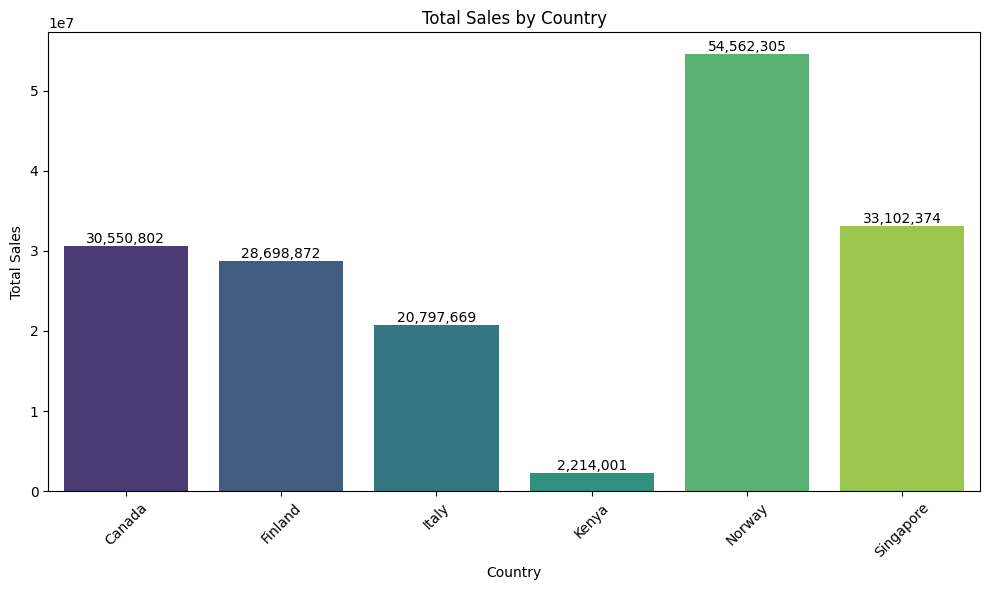

In [20]:
country_sales = train.groupby('country')['num_sold'].sum()

# Visualization
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=country_sales.index, y=country_sales.values, palette='viridis')
plt.title("Total Sales by Country")
plt.xlabel("Country")
plt.ylabel("Total Sales")

# Adding values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Total sales overtime**

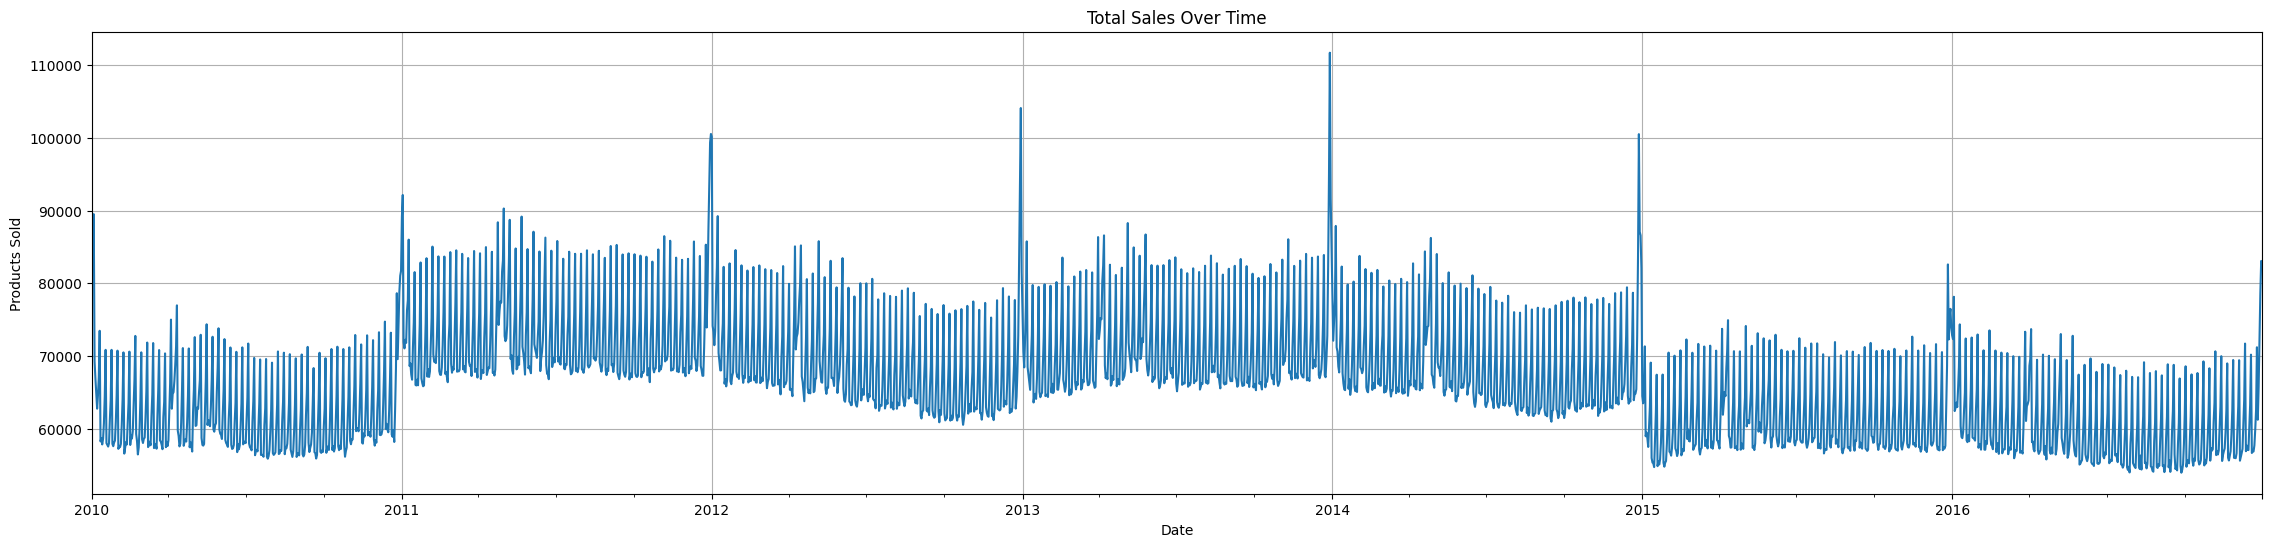

In [21]:
plt.figure(figsize=(28, 6))
train.groupby('date')['num_sold'].sum().plot(title='Total Sales Over Time', xlabel='Date', ylabel='Products Sold')
plt.grid()
plt.show()

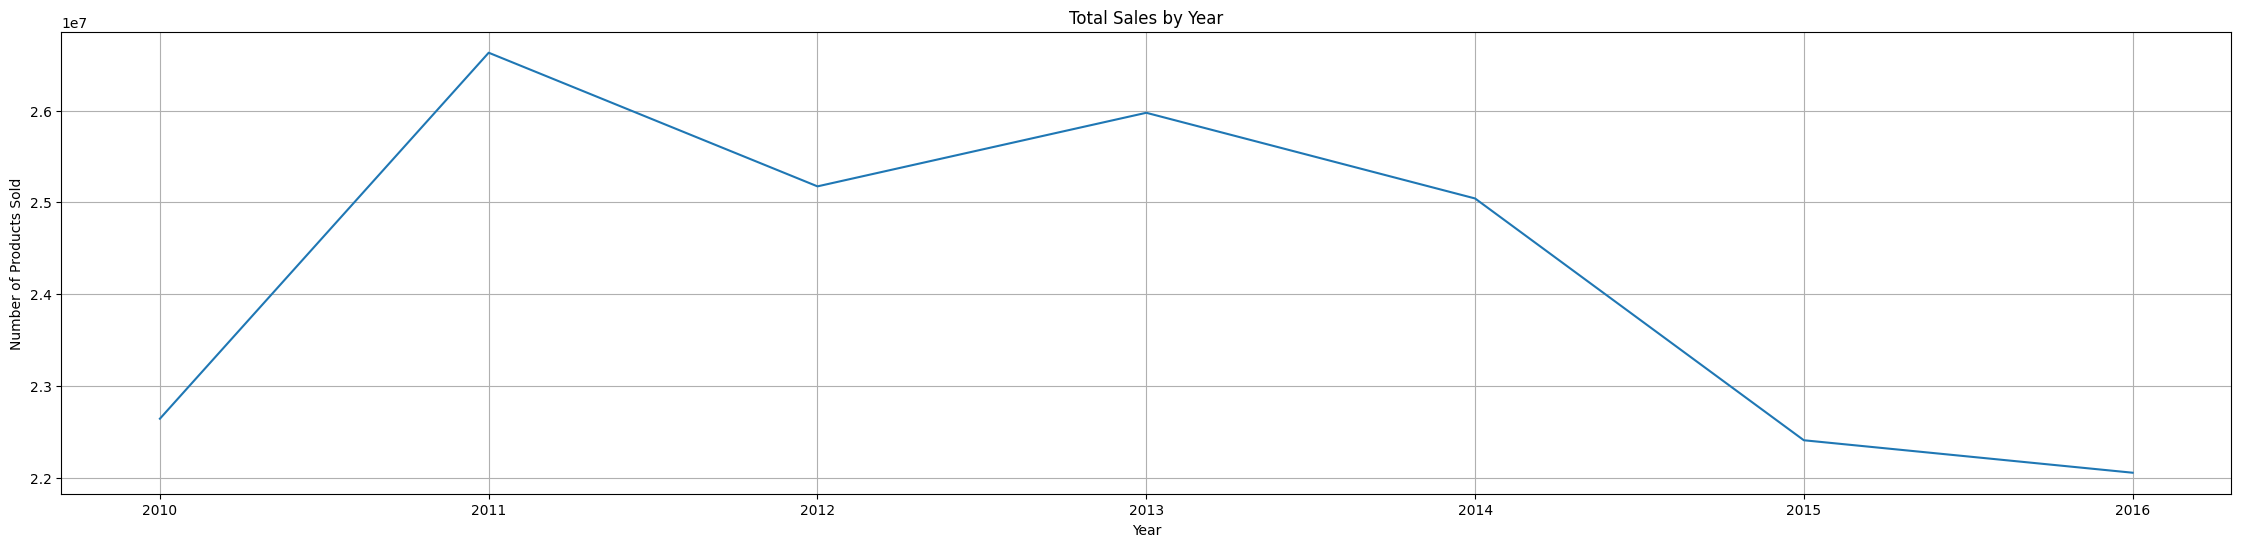

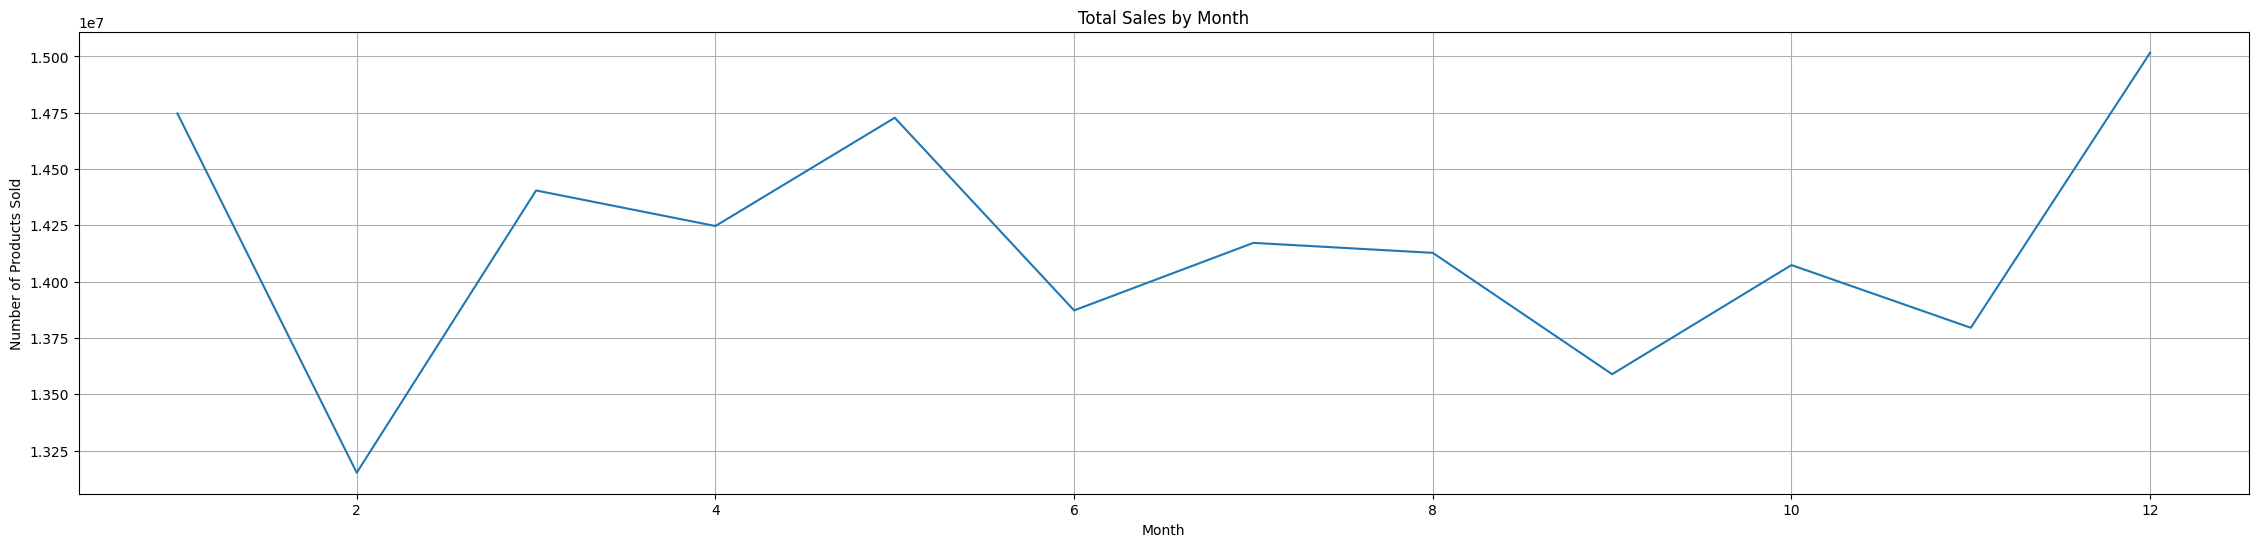

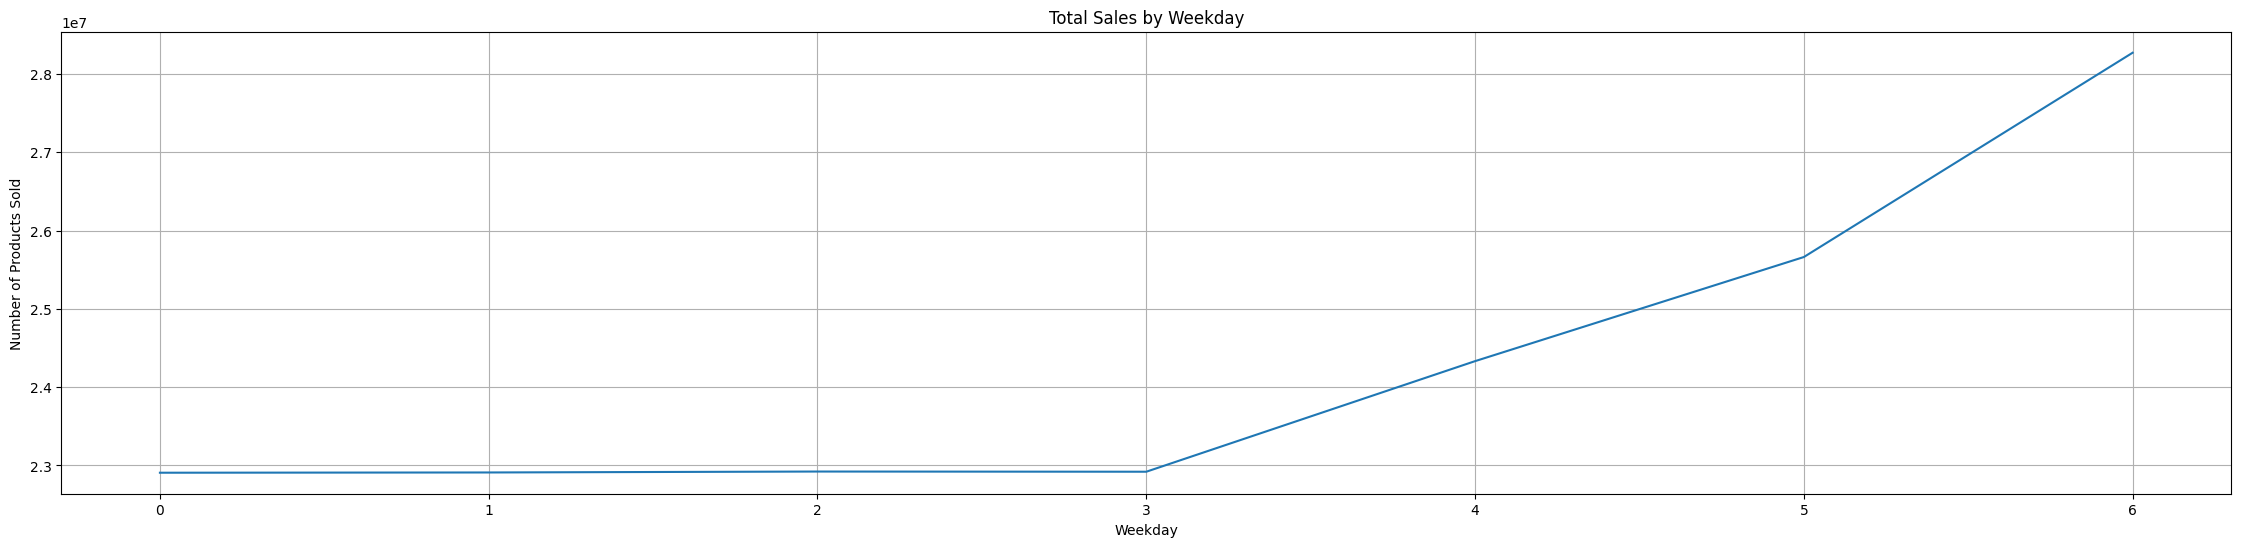

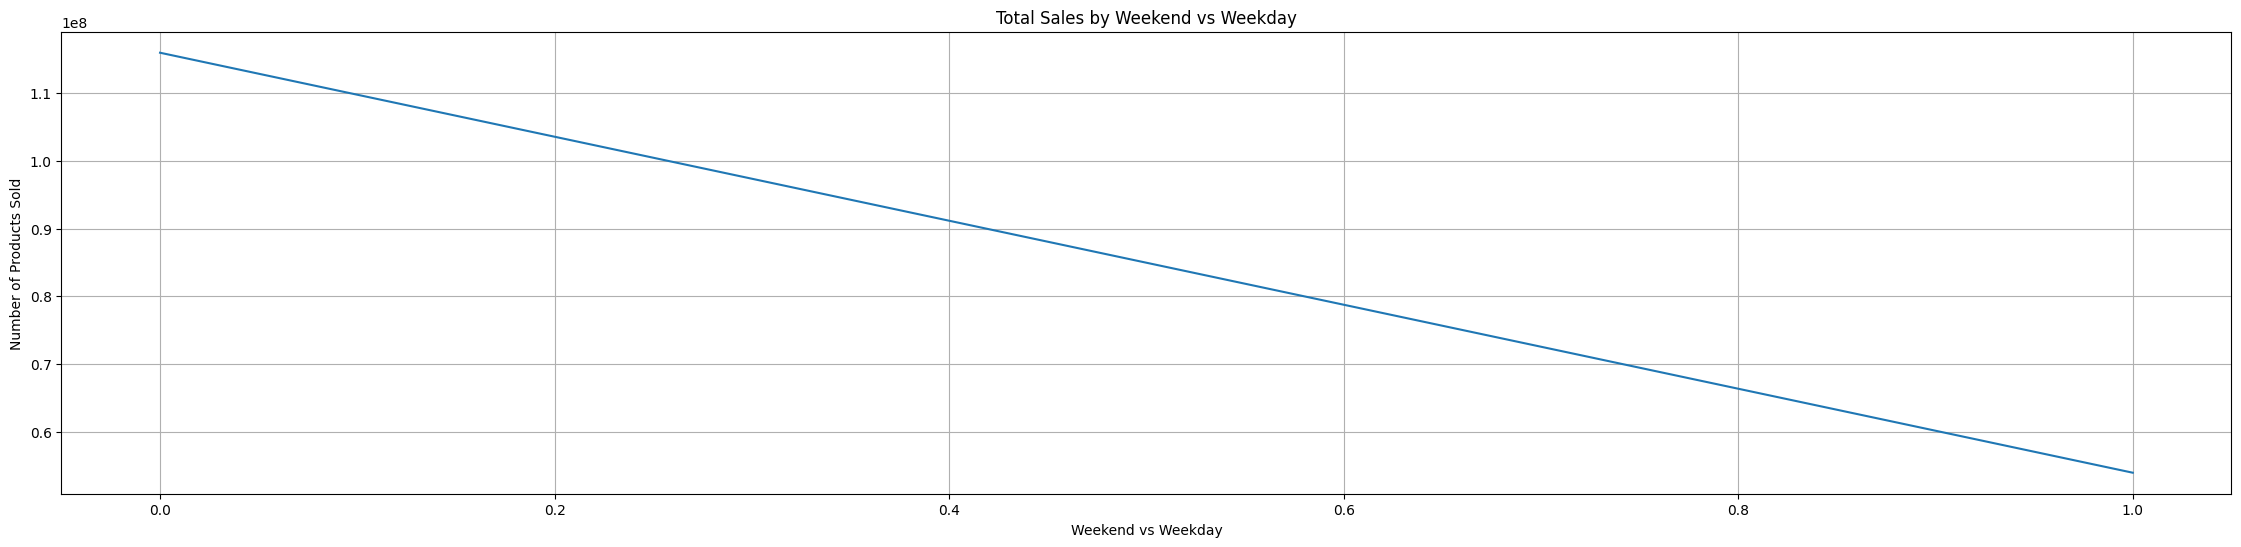

In [22]:
# Total Sales Over Time by Year
plt.figure(figsize=(28, 6))
train.groupby('year')['num_sold'].sum().plot(title='Total Sales by Year', xlabel='Year', ylabel='Number of Products Sold')
plt.grid()
plt.show()

# Total Sales Over Time by Month
plt.figure(figsize=(28, 6))
train.groupby('month')['num_sold'].sum().plot(title='Total Sales by Month', xlabel='Month', ylabel='Number of Products Sold')
plt.grid()
plt.show()

# Total Sales Over Time by Weekday (Monday = 0, Sunday = 6)
plt.figure(figsize=(28, 6))
train.groupby('weekday')['num_sold'].sum().plot(title='Total Sales by Weekday', xlabel='Weekday', ylabel='Number of Products Sold')
plt.grid()
plt.show()

# Total Sales Over Time by Is Weekend (1 = Weekend, 0 = Weekday)
plt.figure(figsize=(28, 6))
train.groupby('is_weekend')['num_sold'].sum().plot(title='Total Sales by Weekend vs Weekday', xlabel='Weekend vs Weekday', ylabel='Number of Products Sold')
plt.grid()
plt.show()

**Yearly Sales Trend**

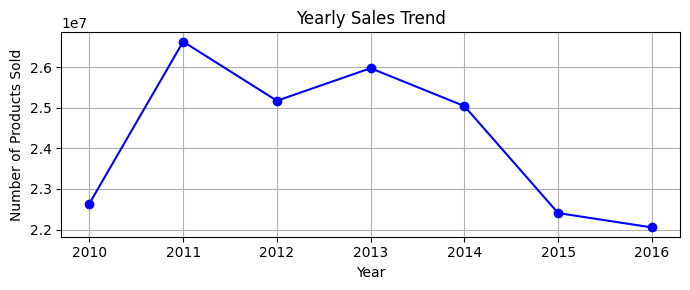

In [23]:
# Group by year and sum the sales
yearly_sales = train.groupby('year')['num_sold'].sum()

plt.figure(figsize=(7, 3))
yearly_sales.plot(kind='line', marker='o', title='Yearly Sales Trend', xlabel='Year', ylabel='Number of Products Sold', color='blue')
plt.grid(True)
plt.tight_layout()
plt.show()

**Monthly Sales Trend**

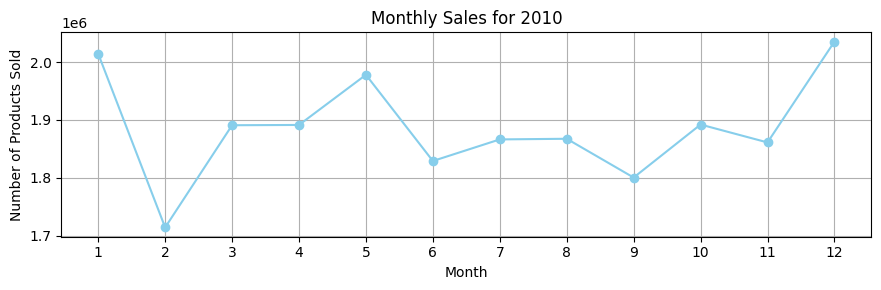

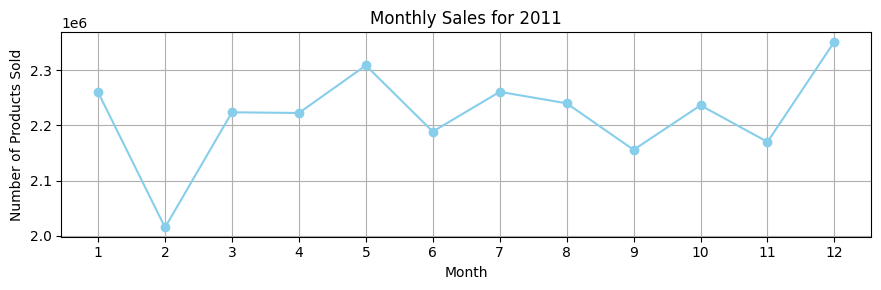

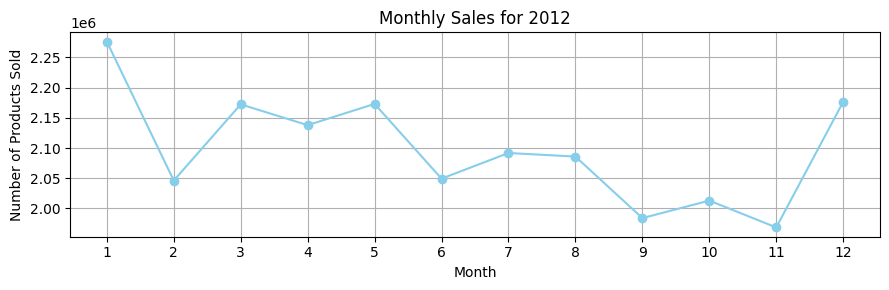

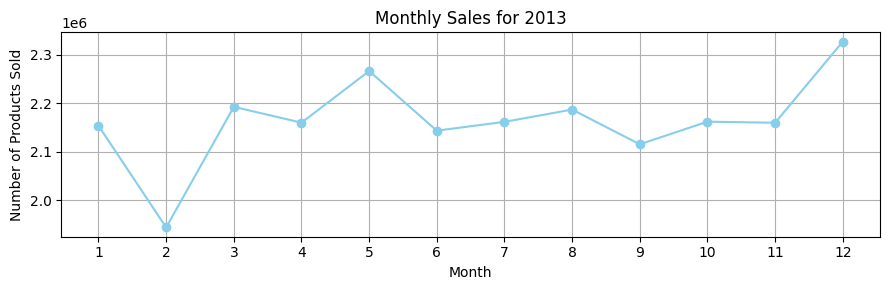

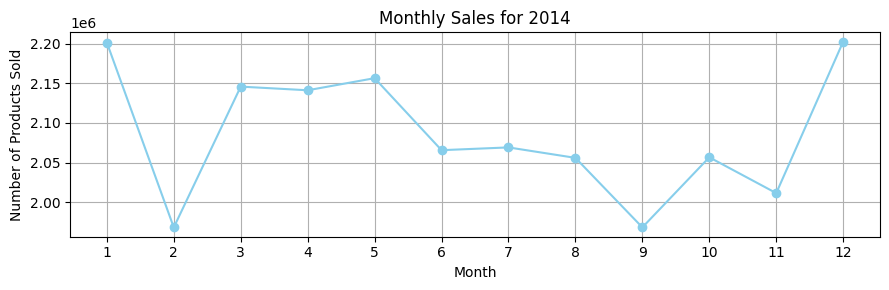

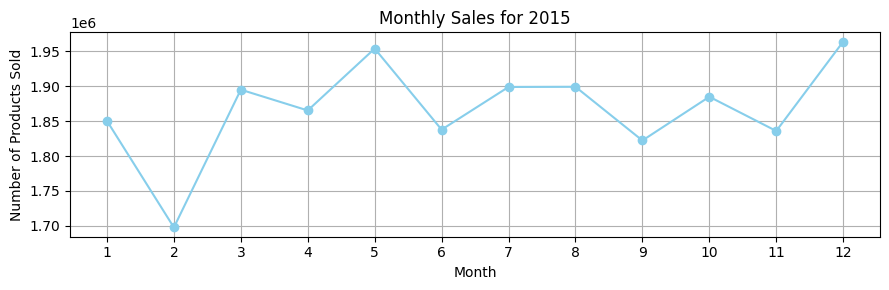

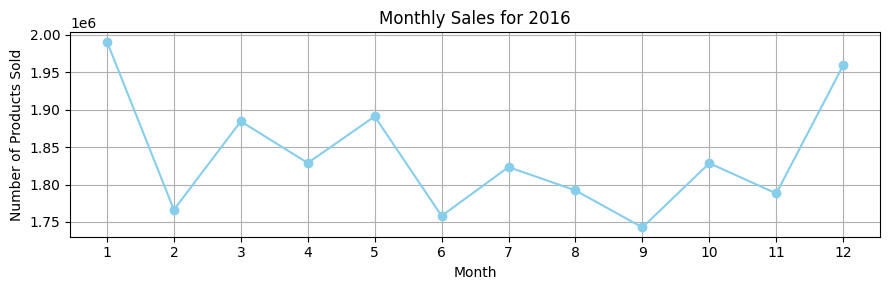

In [24]:
# Group by year and month, and sum the sales
monthly_sales = train.groupby(['year', 'month'])['num_sold'].sum().unstack()

# Plotting sales for each year in separate graphs using line plots
for year in monthly_sales.index:
    plt.figure(figsize=(9, 3))
    monthly_sales.loc[year].plot(kind='line', marker='o', title=f'Monthly Sales for {year}', xlabel='Month', ylabel='Number of Products Sold', color='skyblue')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The graphs suggests that:

1. Sales increase from 2010 to 2012, peak in 2012, and then sharply decline after 2013.
2. Seasonal factors likely influence sales, with December showing high sales, possibly due to holiday shopping. February might experience lower sales due to fewer shopping events or days in the month. This shows **monthly seasonality.**
3. There's a spike in sale on May, and a down spike on September every year. This also shows **monthly seasonality.**
4. Sales increase steadily from the start of the week, with the highest sales toward the end (Friday to Sunday). Which means people are more likely to shop during the weekend compared to weekdays.
5. Weekends tend to generate more sales compared to weekdays.

**Daily Sales Trend**

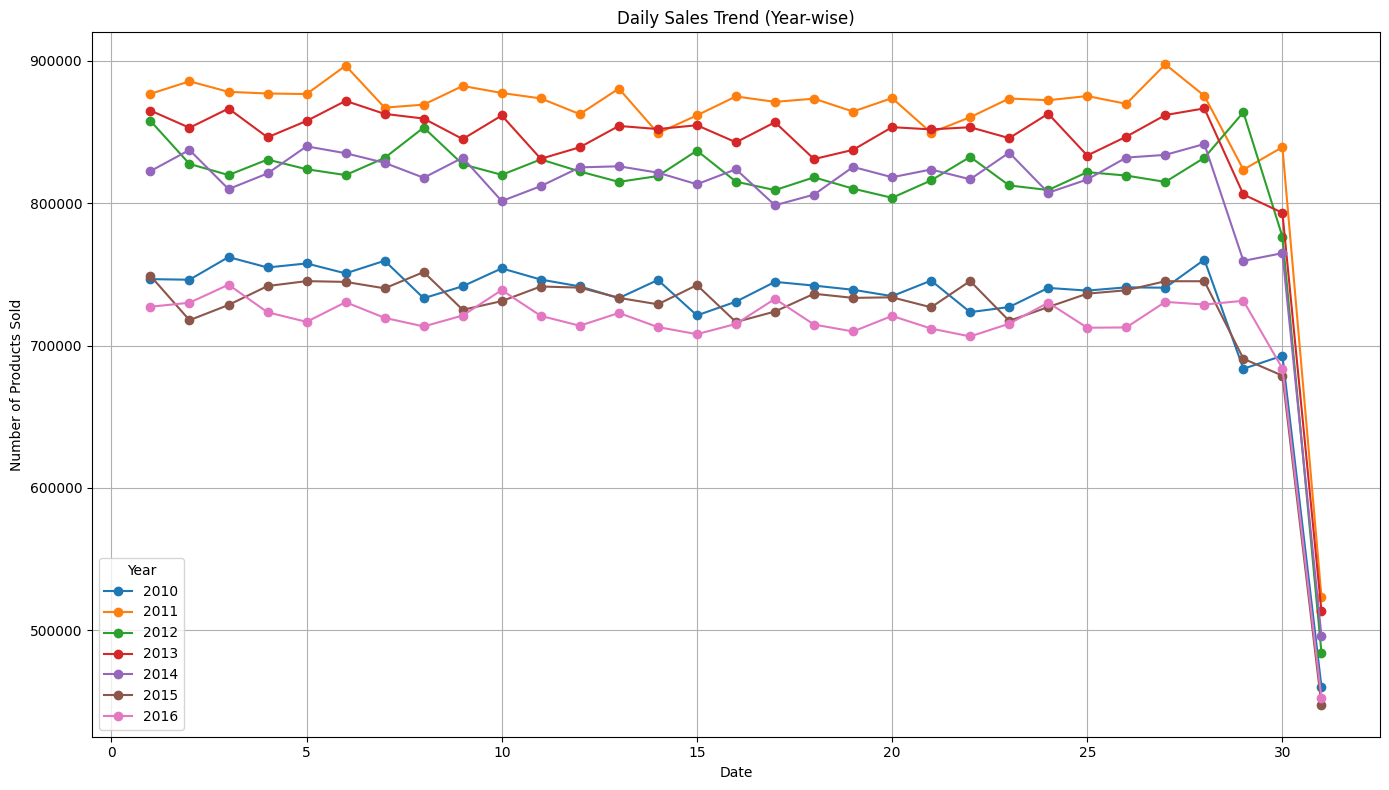

In [25]:
# Group by year and date, and sum the sales
daily_sales_year = train.groupby(['year', 'day'])['num_sold'].sum().unstack()

# Plot all years in the same graph
plt.figure(figsize=(14, 8))
for year in daily_sales_year.index:
    plt.plot(daily_sales_year.columns, daily_sales_year.loc[year], marker='o', label=f'{year}')
plt.title('Daily Sales Trend (Year-wise)')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

**Monthly Sales Trend**

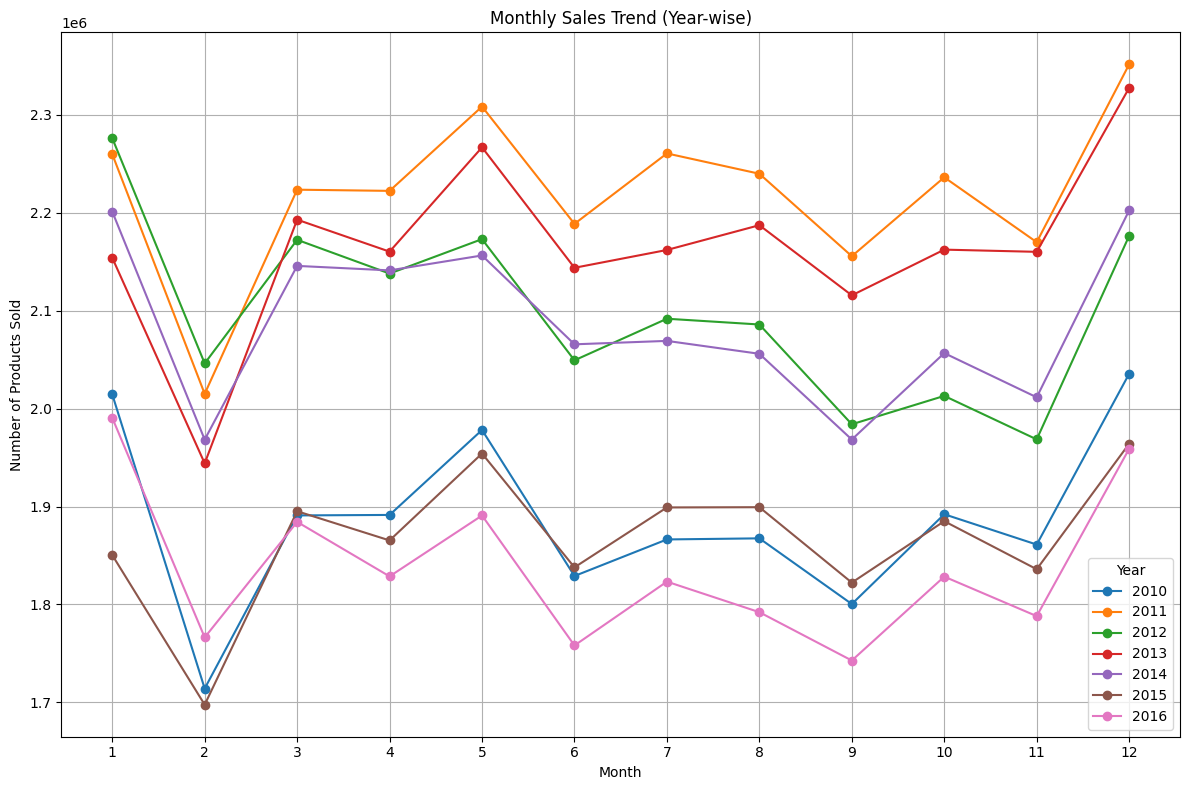

In [26]:
# Group by year and month, and sum the sales
monthly_sales_year = train.groupby(['year', 'month'])['num_sold'].sum().unstack()

# Plot all years in the same graph
plt.figure(figsize=(12, 8))
for year in monthly_sales_year.index:
    plt.plot(monthly_sales_year.columns, monthly_sales_year.loc[year], marker='o', label=f'{year}')
plt.title('Monthly Sales Trend (Year-wise)')
plt.xlabel('Month')
plt.ylabel('Number of Products Sold')
plt.legend(title='Year')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

**Country-wise Sales Trend**

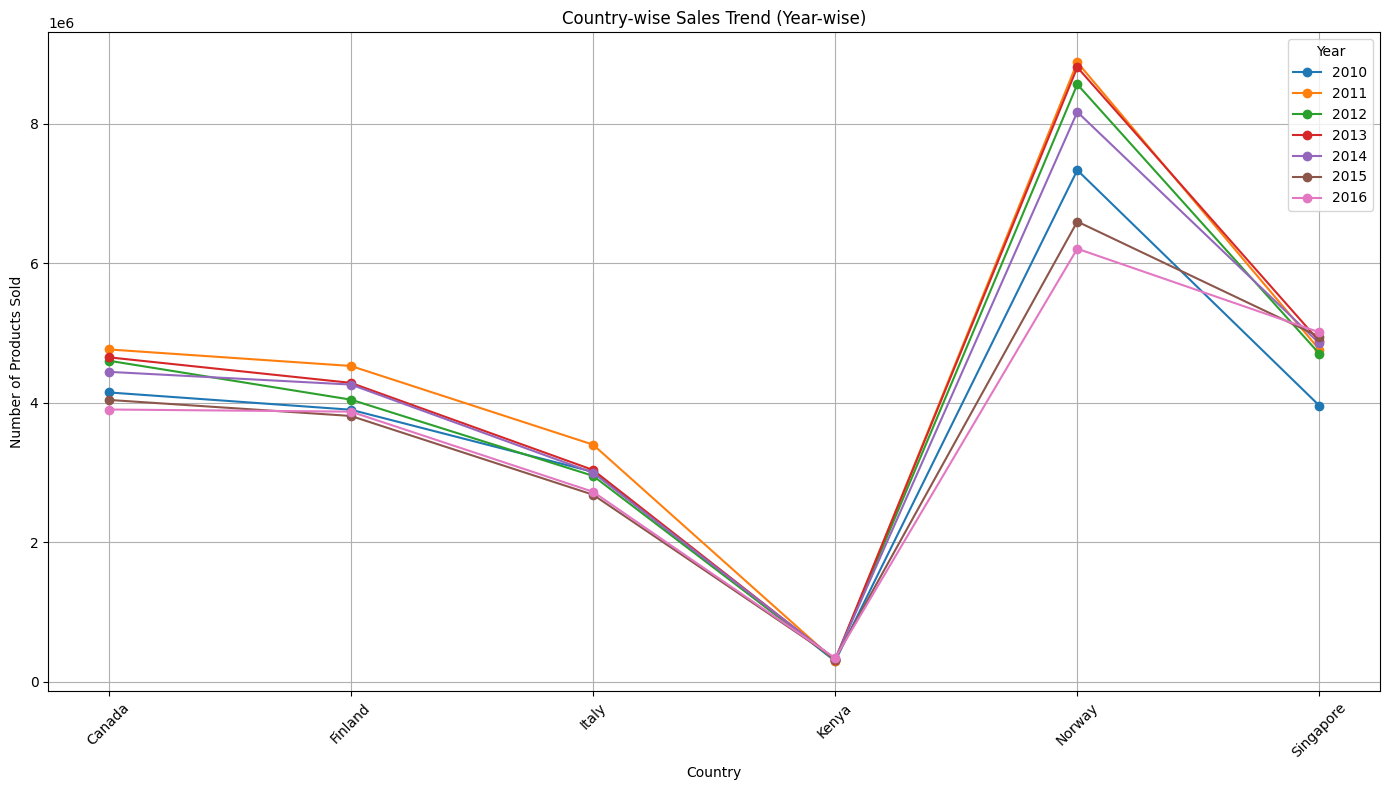

In [27]:
# Group by year and country, and sum the sales
country_sales_year = train.groupby(['year', 'country'])['num_sold'].sum().unstack()

plt.figure(figsize=(14, 8))
for year in country_sales_year.index:
    plt.plot(country_sales_year.columns, country_sales_year.loc[year], marker='o', label=f'{year}')
plt.title('Country-wise Sales Trend (Year-wise)')
plt.xlabel('Country')
plt.ylabel('Number of Products Sold')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Store-wise sales trend**

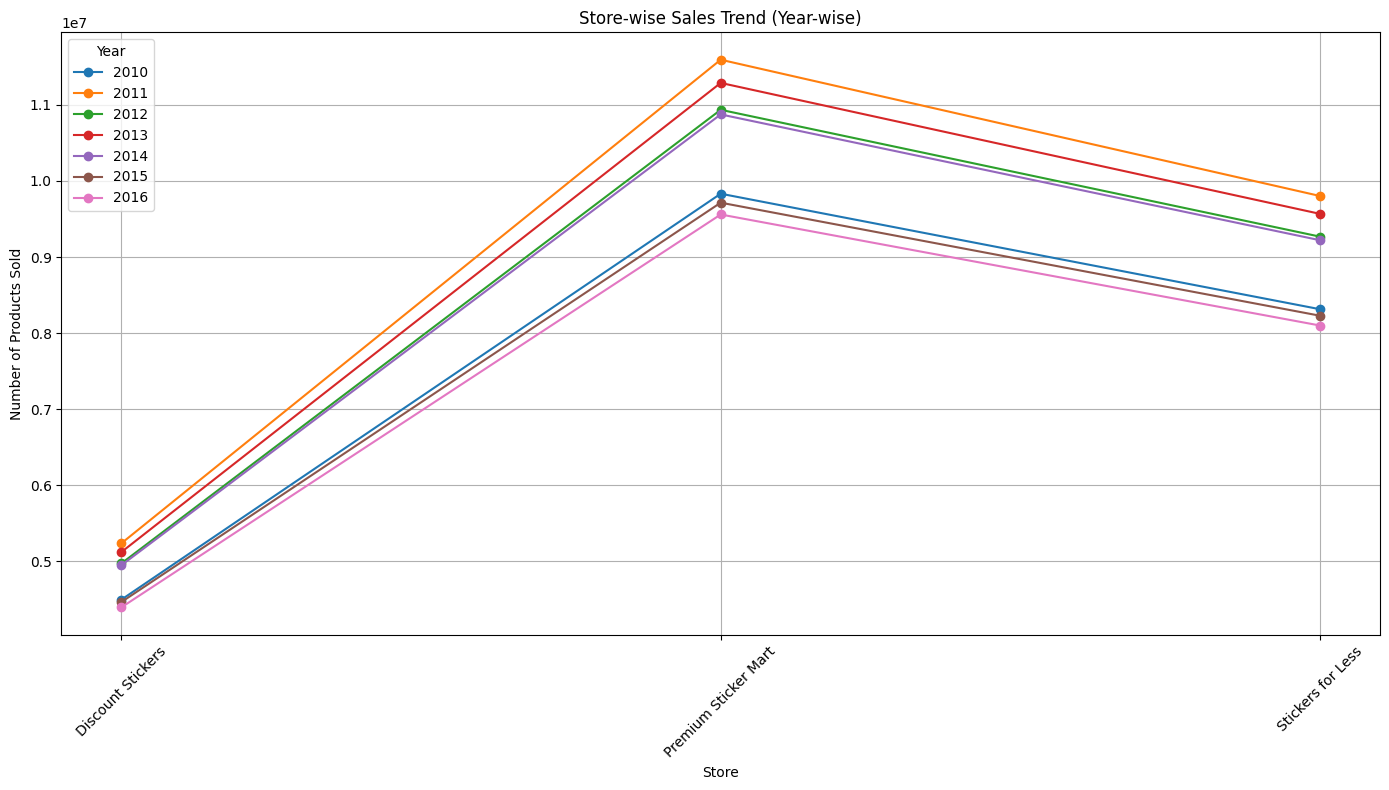

In [28]:
# Group by year and store, and sum the sales
store_sales_year = train.groupby(['year', 'store'])['num_sold'].sum().unstack()

plt.figure(figsize=(14, 8))
for year in store_sales_year.index:
    plt.plot(store_sales_year.columns, store_sales_year.loc[year], marker='o', label=f'{year}')
plt.title('Store-wise Sales Trend (Year-wise)')
plt.xlabel('Store')
plt.ylabel('Number of Products Sold')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

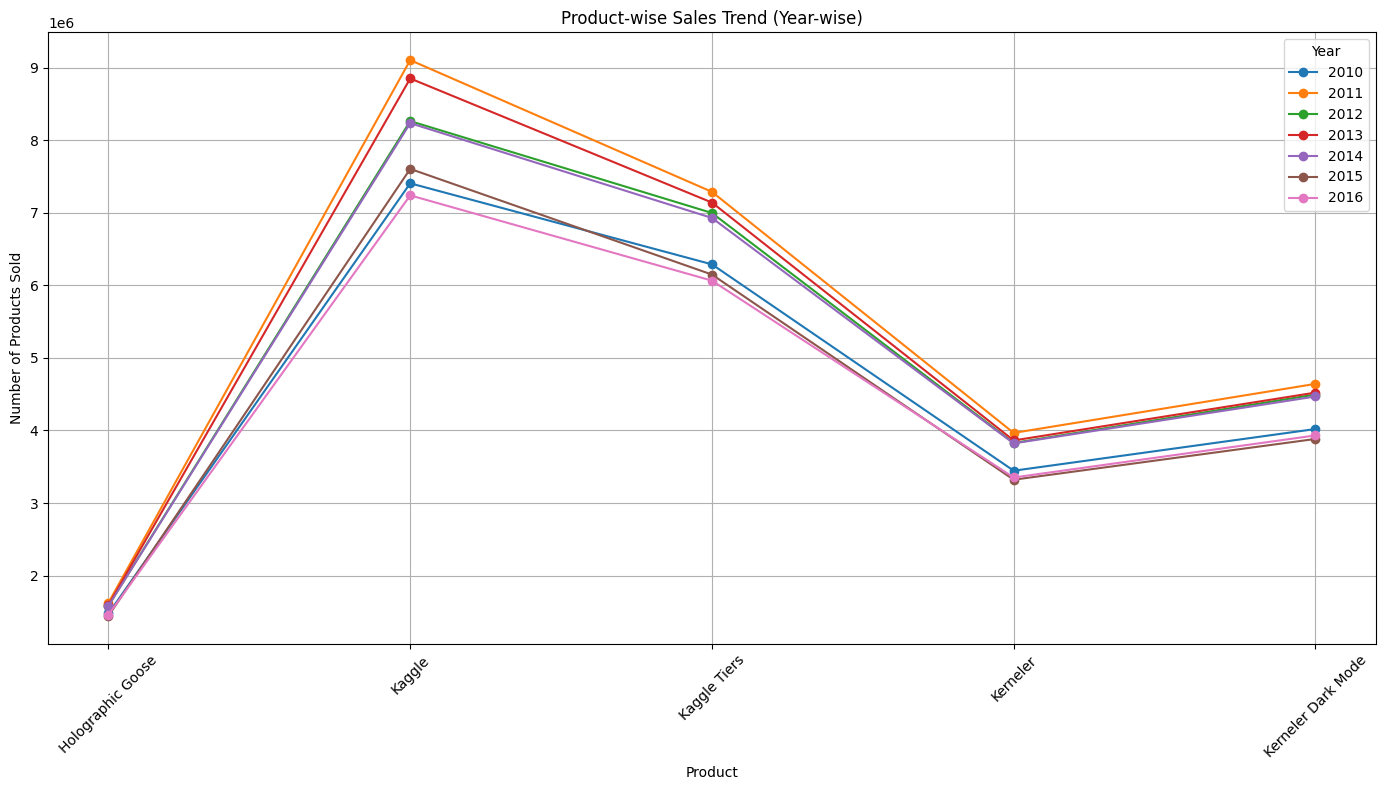

In [29]:
# Group by year and product, and sum the sales
product_sales_year = train.groupby(['year', 'product'])['num_sold'].sum().unstack()

# Plot all years in the same graph
plt.figure(figsize=(14, 8))
for year in product_sales_year.index:
    plt.plot(product_sales_year.columns, product_sales_year.loc[year], marker='o', label=f'{year}')
plt.title('Product-wise Sales Trend (Year-wise)')
plt.xlabel('Product')
plt.ylabel('Number of Products Sold')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Average Sales by Weekday Trend**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


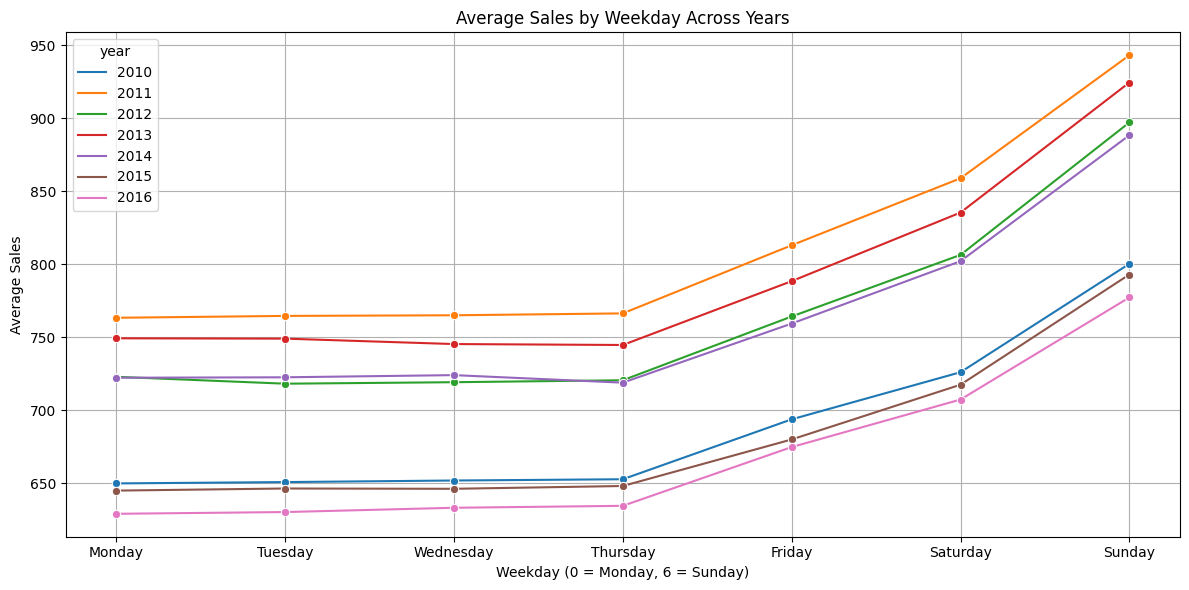

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=train.groupby(['year', 'weekday'])['num_sold'].mean().reset_index(),
    x='weekday',
    y='num_sold',
    hue='year',
    palette='tab10',
    marker='o'
)
plt.title('Average Sales by Weekday Across Years')
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Sales')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid()
plt.tight_layout()
plt.show()

# **Data Preprocessing**

**Cyclical Encoding**
This encoding maps cyclical features into two-dimensional space (sin and cos), where similar values are represented close to each other. This helps the model better learn relationships.
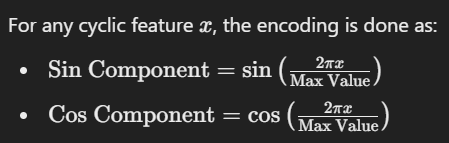

In [31]:
# Cyclical encoding for 'day'
train['day_sin'] = np.sin(2 * np.pi * train['day'] / 31.0)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 31.0)

# Cyclical encoding for 'month'
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12.0)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12.0)

# Cyclical encoding for 'year'
train['year_sin'] = np.sin(2 * np.pi * train['year'] / train['year'].nunique())
train['year_cos'] = np.cos(2 * np.pi * train['year'] / train['year'].nunique())

# Cyclical encoding for 'weekday'
train['weekday_sin'] = np.sin(2 * np.pi * train['weekday'] / 7.0)
train['weekday_cos'] = np.cos(2 * np.pi * train['weekday'] / 7.0)

In [32]:
train = train.drop(columns=['date', 'day', 'month', 'year', 'weekday'])

In [33]:
train = train.drop(columns=['id'])

In [34]:
train.head()

,country,store,product,num_sold,is_weekend,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,weekday_sin,weekday_cos
0,Canada,Discount Stickers,Holographic Goose,592.0,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969
1,Canada,Discount Stickers,Kaggle,973.0,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969
2,Canada,Discount Stickers,Kaggle Tiers,906.0,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969
3,Canada,Discount Stickers,Kerneler,423.0,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969
4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969


In [35]:
# Cyclical encoding for 'day'
test['day_sin'] = np.sin(2 * np.pi * test['day'] / 31.0)
test['day_cos'] = np.cos(2 * np.pi * test['day'] / 31.0)

# Cyclical encoding for 'month'
test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12.0)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12.0)

# Cyclical encoding for 'year'
test['year_sin'] = np.sin(2 * np.pi * test['year'] / test['year'].nunique())
test['year_cos'] = np.cos(2 * np.pi * test['year'] / test['year'].nunique())

# Cyclical encoding for 'weekday'
test['weekday_sin'] = np.sin(2 * np.pi * test['weekday'] / 7.0)
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7.0)

In [36]:
test = test.drop(columns=['id', 'date', 'day', 'month', 'year', 'weekday'])
test.head()

,country,store,product,is_weekend,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,weekday_sin,weekday_cos
0,Canada,Discount Stickers,Holographic Goose,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349
1,Canada,Discount Stickers,Kaggle,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349
2,Canada,Discount Stickers,Kaggle Tiers,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349
3,Canada,Discount Stickers,Kerneler,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349
4,Canada,Discount Stickers,Kerneler Dark Mode,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349


**Outlier Detection**

In [37]:
Q1 = train['num_sold'].quantile(0.25)
Q3 = train['num_sold'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['num_sold'] < lower_bound) | (train['num_sold'] > upper_bound)]
print(f"Number of Outliers in the target column: {len(outliers)}")

Number of Outliers in the target column: 7285


In [38]:
# Function to detect outliers based on IQR method
def detect_outliers(df, cols):
    outliers = pd.DataFrame()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = (df[col] < lower_bound) | (df[col] > upper_bound)
    return outliers

# List of cyclical columns to check for outliers
cyclical_cols = ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos', 'weekday_sin', 'weekday_cos']

# Detect outliers in the cyclical columns
outliers_cyclical = detect_outliers(train, cyclical_cols)

# Check how many outliers in each cyclical column
outliers_by_cyclical_column = outliers_cyclical.sum()
print("Outliers in Cyclical Columns:")
print(outliers_by_cyclical_column)

Outliers in Cyclical Columns:
day_sin        0
day_cos        0
month_sin      0
month_cos      0
year_sin       0
year_cos       0
weekday_sin    0
weekday_cos    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


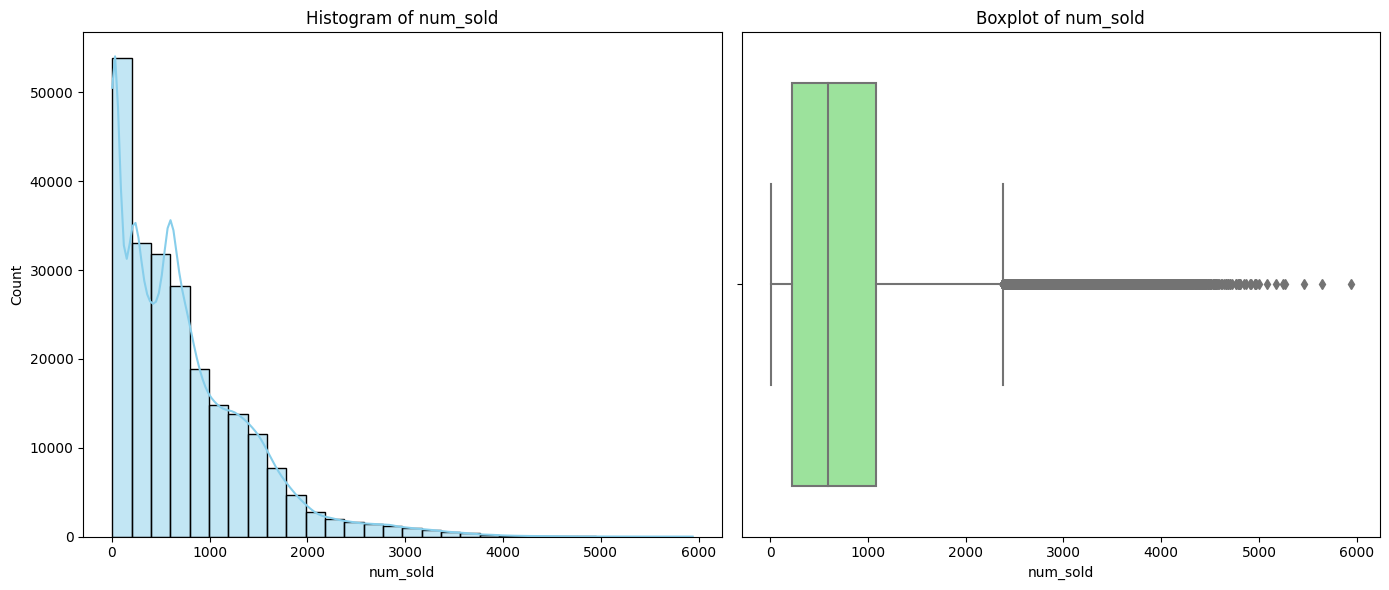

Skewness of num_sold: 1.4558376036162721


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train['num_sold'], kde=True, color='skyblue', bins=30)
plt.title('Histogram of num_sold')

plt.subplot(1, 2, 2)
sns.boxplot(x=train['num_sold'], color='lightgreen')
plt.title('Boxplot of num_sold')

plt.tight_layout()
plt.show()

skewness = train['num_sold'].skew()
print(f"Skewness of num_sold: {skewness}")

**'num_sold' is highly skewed**

**log transformation is good strategy to handle outliers and skewness, especially if the sales data is right-skewed or contains extreme values.**

In [40]:
train['num_sold'] = np.log(train['num_sold'] + 1)

In [41]:
def target_encoding_multiple_columns(df, target_column, categorical_columns, dataset_column='dataset'):
    for col in categorical_columns:
        target_mean = df[df[dataset_column] == 'train'].groupby(col)[target_column].mean()
        df[f'{col}_encoded'] = df[col].map(target_mean)
        df[f'{col}_encoded'].fillna(df[target_column].mean(), inplace=True)
    return df

categorical_columns = ['country', 'store', 'product']
train['dataset'] = 'train'
train = target_encoding_multiple_columns(train, target_column='num_sold', categorical_columns=categorical_columns, dataset_column='dataset')
train.drop(columns=['dataset'], inplace=True)

In [42]:
test['dataset'] = 'test'

for col in categorical_columns:
    target_mean = train.groupby(col)['num_sold'].mean()
    test[f'{col}_encoded'] = test[col].map(target_mean)
    test[f'{col}_encoded'].fillna(train['num_sold'].mean(), inplace=True)

test.drop(columns=['dataset'], inplace=True)

In [43]:
train.drop(columns=['country', 'store', 'product'], inplace=True)

In [44]:
train.head()

,num_sold,is_weekend,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,weekday_sin,weekday_cos,country_encoded,store_encoded,product_encoded
0,6.385194,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969,6.499828,5.540709,5.006029
1,6.881411,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969,6.499828,5.540709,6.540707
2,6.810142,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969,6.499828,5.540709,6.350640
3,6.049733,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969,6.499828,5.540709,5.744497
4,6.198479,0,0.201299,0.97953,0.5,0.866025,0.781831,0.62349,-0.433884,-0.900969,6.499828,5.540709,5.895253


In [45]:
test.drop(columns=['country', 'store', 'product'], inplace=True)

In [46]:
test.head()

,is_weekend,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,weekday_sin,weekday_cos,country_encoded,store_encoded,product_encoded
0,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349,6.499828,5.540709,5.006029
1,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349,6.499828,5.540709,6.540707
2,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349,6.499828,5.540709,6.350640
3,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349,6.499828,5.540709,5.744497
4,1,0.201299,0.97953,0.5,0.866025,0.866025,-0.5,-0.781831,0.62349,6.499828,5.540709,5.895253


# **Model Training**

In [47]:
X= train.drop(columns=['num_sold'])
y = train['num_sold']

In [48]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import optuna

# Assuming X and y are already defined
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mape',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'random_state': 42,
        'device': 'gpu'
    }
    
    model = lgb.LGBMRegressor(**params)
    
    # Train the model with early stopping using callbacks
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mape',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    y_pred = model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best MAPE:", study.best_value)

[I 2025-01-15 18:05:03,890] A new study created in memory with name: no-name-4222f92b-a4e8-42f9-9a07-af4010d6f3e8
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
<ipython-input-48-5983b088ceb7>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugg

[LightGBM] [Warning] lambda_l2 is set=0.0005589150066197242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005589150066197242
[LightGBM] [Warning] lambda_l2 is set=0.0005589150066197242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005589150066197242
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003401 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0005589150066197242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005589150066197242
[LightGBM] [Info] Start training from score 5.906513
[Lig

[I 2025-01-15 18:05:09,775] Trial 0 finished with value: 0.009170336271977582 and parameters: {'n_estimators': 180, 'learning_rate': 0.18470923206464762, 'max_depth': 14, 'reg_alpha': 0.6755395228370517, 'lambda_l2': 0.0005589150066197242, 'min_child_samples': 100, 'colsample_bytree': 0.6810528408699861, 'subsample': 0.9081292127316963}. Best is trial 0 with value: 0.009170336271977582.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e

[LightGBM] [Warning] lambda_l2 is set=0.00223800517441275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00223800517441275
[LightGBM] [Warning] lambda_l2 is set=0.00223800517441275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00223800517441275
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003300 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.00223800517441275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00223800517441275
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:05:18,961] Trial 1 finished with value: 0.01002430028349506 and parameters: {'n_estimators': 866, 'learning_rate': 0.02354054098356795, 'max_depth': 12, 'reg_alpha': 0.09779607347949706, 'lambda_l2': 0.00223800517441275, 'min_child_samples': 66, 'colsample_bytree': 0.6030264323063208, 'subsample': 0.555780771940761}. Best is trial 0 with value: 0.009170336271977582.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 

[LightGBM] [Warning] lambda_l2 is set=0.0069710864083725186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0069710864083725186
[LightGBM] [Warning] lambda_l2 is set=0.0069710864083725186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0069710864083725186
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003417 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0069710864083725186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0069710864083725186
[LightGBM] [Info] Start training from score 5.906513
[Lig

[I 2025-01-15 18:05:24,503] Trial 2 finished with value: 0.010384800526859337 and parameters: {'n_estimators': 517, 'learning_rate': 0.02216964697215955, 'max_depth': 11, 'reg_alpha': 0.027104044456654267, 'lambda_l2': 0.0069710864083725186, 'min_child_samples': 60, 'colsample_bytree': 0.9175187232741187, 'subsample': 0.7674463404483205}. Best is trial 0 with value: 0.009170336271977582.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.05171142991929329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05171142991929329
[LightGBM] [Warning] lambda_l2 is set=0.05171142991929329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05171142991929329
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003537 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.05171142991929329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05171142991929329
[LightGBM] [Info] Start training from score 5.906513


[I 2025-01-15 18:05:26,135] Trial 3 finished with value: 0.01397995391772133 and parameters: {'n_estimators': 129, 'learning_rate': 0.05283662130002474, 'max_depth': 6, 'reg_alpha': 0.003640077633087821, 'lambda_l2': 0.05171142991929329, 'min_child_samples': 39, 'colsample_bytree': 0.974784396769782, 'subsample': 0.525773884347859}. Best is trial 0 with value: 0.009170336271977582.


[LightGBM] [Warning] lambda_l2 is set=0.05171142991929329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05171142991929329


<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
<ipython-input-48-5983b088ceb7>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-4, 1.0),
<ipython-input-48-5983b088ceb7>:20: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] lambda_l2 is set=0.0030470509703882315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030470509703882315
[LightGBM] [Warning] lambda_l2 is set=0.0030470509703882315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030470509703882315
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003557 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0030470509703882315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030470509703882315
[LightGBM] [Info] Start training from score 5.906513
[Lig

[I 2025-01-15 18:05:28,012] Trial 4 finished with value: 0.009907534643196074 and parameters: {'n_estimators': 164, 'learning_rate': 0.0907105306661876, 'max_depth': 8, 'reg_alpha': 0.010174110403460715, 'lambda_l2': 0.0030470509703882315, 'min_child_samples': 44, 'colsample_bytree': 0.946249536170896, 'subsample': 0.7214293931369284}. Best is trial 0 with value: 0.009170336271977582.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4

[LightGBM] [Warning] lambda_l2 is set=0.0001295567044989688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001295567044989688
[LightGBM] [Warning] lambda_l2 is set=0.0001295567044989688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001295567044989688
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003407 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0001295567044989688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001295567044989688
[LightGBM] [Info] Start training from score 5.906513
[Lig

[I 2025-01-15 18:05:33,853] Trial 5 finished with value: 0.015364497683754518 and parameters: {'n_estimators': 509, 'learning_rate': 0.0111921794078172, 'max_depth': 10, 'reg_alpha': 0.8764712057864127, 'lambda_l2': 0.0001295567044989688, 'min_child_samples': 37, 'colsample_bytree': 0.8783570284236173, 'subsample': 0.880965863251034}. Best is trial 0 with value: 0.009170336271977582.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4,

[LightGBM] [Warning] lambda_l2 is set=0.025950501540459053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025950501540459053
[LightGBM] [Warning] lambda_l2 is set=0.025950501540459053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025950501540459053
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003406 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.025950501540459053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025950501540459053
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:05:40,112] Trial 6 finished with value: 0.008798390478572305 and parameters: {'n_estimators': 664, 'learning_rate': 0.04690122757321685, 'max_depth': 10, 'reg_alpha': 0.02334059895420311, 'lambda_l2': 0.025950501540459053, 'min_child_samples': 62, 'colsample_bytree': 0.8031811774018075, 'subsample': 0.5820446217880331}. Best is trial 6 with value: 0.008798390478572305.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-

[LightGBM] [Warning] lambda_l2 is set=0.030733092575572867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030733092575572867
[LightGBM] [Warning] lambda_l2 is set=0.030733092575572867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030733092575572867
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003392 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.030733092575572867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030733092575572867
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:05:45,945] Trial 7 finished with value: 0.01889925255829652 and parameters: {'n_estimators': 509, 'learning_rate': 0.013845241812916497, 'max_depth': 12, 'reg_alpha': 0.0004042787089040352, 'lambda_l2': 0.030733092575572867, 'min_child_samples': 48, 'colsample_bytree': 0.6074496061368838, 'subsample': 0.7495790563290609}. Best is trial 6 with value: 0.008798390478572305.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.0018510669987195922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018510669987195922
[LightGBM] [Warning] lambda_l2 is set=0.0018510669987195922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018510669987195922
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003345 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0018510669987195922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018510669987195922
[LightGBM] [Info] Start training from score 5.906513
[Lig

[I 2025-01-15 18:05:49,999] Trial 8 finished with value: 0.009382538162202145 and parameters: {'n_estimators': 408, 'learning_rate': 0.04925043962125951, 'max_depth': 9, 'reg_alpha': 0.49054331769865617, 'lambda_l2': 0.0018510669987195922, 'min_child_samples': 55, 'colsample_bytree': 0.7899095855592579, 'subsample': 0.7045097877651078}. Best is trial 6 with value: 0.008798390478572305.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-

[LightGBM] [Warning] lambda_l2 is set=0.0006709163031046979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006709163031046979
[LightGBM] [Warning] lambda_l2 is set=0.0006709163031046979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006709163031046979
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003300 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0006709163031046979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006709163031046979
[LightGBM] [Info] Start training from score 5.906513
[Lig

[I 2025-01-15 18:05:53,711] Trial 9 finished with value: 0.008905672628855983 and parameters: {'n_estimators': 414, 'learning_rate': 0.08721172046577856, 'max_depth': 7, 'reg_alpha': 0.03485789301317433, 'lambda_l2': 0.0006709163031046979, 'min_child_samples': 78, 'colsample_bytree': 0.618530485497893, 'subsample': 0.6994453272171987}. Best is trial 6 with value: 0.008798390478572305.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4

[LightGBM] [Warning] lambda_l2 is set=0.9428059126915316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9428059126915316
[LightGBM] [Warning] lambda_l2 is set=0.9428059126915316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9428059126915316
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003442 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.9428059126915316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9428059126915316
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] l

[I 2025-01-15 18:05:59,133] Trial 10 finished with value: 0.0080499443376929 and parameters: {'n_estimators': 812, 'learning_rate': 0.2034225654966996, 'max_depth': 15, 'reg_alpha': 0.0011896662224306328, 'lambda_l2': 0.9428059126915316, 'min_child_samples': 20, 'colsample_bytree': 0.7839789263268165, 'subsample': 0.6111237947460253}. Best is trial 10 with value: 0.0080499443376929.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 

[LightGBM] [Warning] lambda_l2 is set=0.8849679287521152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8849679287521152
[LightGBM] [Warning] lambda_l2 is set=0.8849679287521152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8849679287521152
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003442 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.8849679287521152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8849679287521152
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] l

[I 2025-01-15 18:06:04,306] Trial 11 finished with value: 0.008074891113507676 and parameters: {'n_estimators': 811, 'learning_rate': 0.2899450696923394, 'max_depth': 15, 'reg_alpha': 0.0005727306644781458, 'lambda_l2': 0.8849679287521152, 'min_child_samples': 26, 'colsample_bytree': 0.8023874385637572, 'subsample': 0.6084229194336302}. Best is trial 10 with value: 0.0080499443376929.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4

[LightGBM] [Warning] lambda_l2 is set=0.865528512757041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.865528512757041
[LightGBM] [Warning] lambda_l2 is set=0.865528512757041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.865528512757041
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003527 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.865528512757041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.865528512757041
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] lambda_

[I 2025-01-15 18:06:10,938] Trial 12 finished with value: 0.00805993168841915 and parameters: {'n_estimators': 997, 'learning_rate': 0.28576382723514365, 'max_depth': 15, 'reg_alpha': 0.00018642265703227196, 'lambda_l2': 0.865528512757041, 'min_child_samples': 21, 'colsample_bytree': 0.7714673008302184, 'subsample': 0.6160770477844731}. Best is trial 10 with value: 0.0080499443376929.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4

[LightGBM] [Warning] lambda_l2 is set=0.7917525766064828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7917525766064828
[LightGBM] [Warning] lambda_l2 is set=0.7917525766064828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7917525766064828
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003420 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.7917525766064828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7917525766064828
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] l

[I 2025-01-15 18:06:16,033] Trial 13 finished with value: 0.00807179308854369 and parameters: {'n_estimators': 986, 'learning_rate': 0.29525470020285977, 'max_depth': 14, 'reg_alpha': 0.0001092977164384742, 'lambda_l2': 0.7917525766064828, 'min_child_samples': 25, 'colsample_bytree': 0.7324794971228512, 'subsample': 0.6400155659367339}. Best is trial 10 with value: 0.0080499443376929.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4

[LightGBM] [Warning] lambda_l2 is set=0.20846477303287475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20846477303287475
[LightGBM] [Warning] lambda_l2 is set=0.20846477303287475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20846477303287475
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003427 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.20846477303287475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20846477303287475
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:06:22,943] Trial 14 finished with value: 0.00801900544370511 and parameters: {'n_estimators': 1000, 'learning_rate': 0.15344435849233254, 'max_depth': 15, 'reg_alpha': 0.0015965163472695491, 'lambda_l2': 0.20846477303287475, 'min_child_samples': 20, 'colsample_bytree': 0.8642137292698431, 'subsample': 0.831820646850157}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e

[LightGBM] [Warning] lambda_l2 is set=0.17767634740491528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17767634740491528
[LightGBM] [Warning] lambda_l2 is set=0.17767634740491528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17767634740491528
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003667 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.17767634740491528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17767634740491528
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:06:28,214] Trial 15 finished with value: 0.008101057860820155 and parameters: {'n_estimators': 766, 'learning_rate': 0.14570820975080406, 'max_depth': 13, 'reg_alpha': 0.0017360127901337899, 'lambda_l2': 0.17767634740491528, 'min_child_samples': 31, 'colsample_bytree': 0.8626632821025194, 'subsample': 0.9820706848264348}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.17561605724103121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17561605724103121
[LightGBM] [Warning] lambda_l2 is set=0.17561605724103121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17561605724103121
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003396 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.17561605724103121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17561605724103121
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:06:34,364] Trial 16 finished with value: 0.008079504504118654 and parameters: {'n_estimators': 888, 'learning_rate': 0.1374148116625598, 'max_depth': 13, 'reg_alpha': 0.002076801117333308, 'lambda_l2': 0.17561605724103121, 'min_child_samples': 78, 'colsample_bytree': 0.8560558636145958, 'subsample': 0.853611606004742}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4

[LightGBM] [Warning] lambda_l2 is set=0.1875360849118264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1875360849118264
[LightGBM] [Warning] lambda_l2 is set=0.1875360849118264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1875360849118264
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003346 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.1875360849118264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1875360849118264
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] N

[I 2025-01-15 18:06:40,963] Trial 17 finished with value: 0.00861065827981145 and parameters: {'n_estimators': 657, 'learning_rate': 0.0896293902047041, 'max_depth': 5, 'reg_alpha': 0.0006959907724954094, 'lambda_l2': 0.1875360849118264, 'min_child_samples': 20, 'colsample_bytree': 0.717020638748868, 'subsample': 0.8104932430562911}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 

[LightGBM] [Warning] lambda_l2 is set=0.3033740507673967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3033740507673967
[LightGBM] [Warning] lambda_l2 is set=0.3033740507673967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3033740507673967
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.005255 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.3033740507673967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3033740507673967
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] l

[I 2025-01-15 18:06:46,186] Trial 18 finished with value: 0.008043596979489432 and parameters: {'n_estimators': 740, 'learning_rate': 0.18178140575190668, 'max_depth': 15, 'reg_alpha': 0.006640914136532781, 'lambda_l2': 0.3033740507673967, 'min_child_samples': 34, 'colsample_bytree': 0.8391384229885234, 'subsample': 0.9539375919571524}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-

[LightGBM] [Warning] lambda_l2 is set=0.0816299002982607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0816299002982607
[LightGBM] [Warning] lambda_l2 is set=0.0816299002982607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0816299002982607
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003453 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0816299002982607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0816299002982607
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] l

[I 2025-01-15 18:06:51,010] Trial 19 finished with value: 0.008124940491629252 and parameters: {'n_estimators': 675, 'learning_rate': 0.13723372091242328, 'max_depth': 13, 'reg_alpha': 0.006056915272012068, 'lambda_l2': 0.0816299002982607, 'min_child_samples': 31, 'colsample_bytree': 0.9150421669535131, 'subsample': 0.9689685525220552}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-

[LightGBM] [Warning] lambda_l2 is set=0.31916555607148883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31916555607148883
[LightGBM] [Warning] lambda_l2 is set=0.31916555607148883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31916555607148883
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003330 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.31916555607148883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31916555607148883
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:06:58,181] Trial 20 finished with value: 0.008248977250729731 and parameters: {'n_estimators': 913, 'learning_rate': 0.07125291082374559, 'max_depth': 14, 'reg_alpha': 0.18883001673786873, 'lambda_l2': 0.31916555607148883, 'min_child_samples': 48, 'colsample_bytree': 0.997174166483884, 'subsample': 0.9268902523913423}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4

[LightGBM] [Warning] lambda_l2 is set=0.3789139982256429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3789139982256429
[LightGBM] [Warning] lambda_l2 is set=0.3789139982256429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3789139982256429
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003317 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.3789139982256429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3789139982256429
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] l

[I 2025-01-15 18:07:03,206] Trial 21 finished with value: 0.008030857931434167 and parameters: {'n_estimators': 755, 'learning_rate': 0.2082311186375457, 'max_depth': 15, 'reg_alpha': 0.0015301284278769615, 'lambda_l2': 0.3789139982256429, 'min_child_samples': 32, 'colsample_bytree': 0.8469837354852463, 'subsample': 0.8242145619198064}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-

[LightGBM] [Warning] lambda_l2 is set=0.3320459564618487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3320459564618487
[LightGBM] [Warning] lambda_l2 is set=0.3320459564618487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3320459564618487
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003365 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.3320459564618487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3320459564618487
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] l

[I 2025-01-15 18:07:08,049] Trial 22 finished with value: 0.008063895646667178 and parameters: {'n_estimators': 726, 'learning_rate': 0.20202452616014457, 'max_depth': 15, 'reg_alpha': 0.007355151432101397, 'lambda_l2': 0.3320459564618487, 'min_child_samples': 34, 'colsample_bytree': 0.8450526703210802, 'subsample': 0.8296603867016703}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-

[LightGBM] [Warning] lambda_l2 is set=0.08070864830462983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08070864830462983
[LightGBM] [Warning] lambda_l2 is set=0.08070864830462983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08070864830462983
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003421 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.08070864830462983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08070864830462983
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:07:12,540] Trial 23 finished with value: 0.008202410240103066 and parameters: {'n_estimators': 598, 'learning_rate': 0.11798191229292382, 'max_depth': 14, 'reg_alpha': 0.0026022597786047983, 'lambda_l2': 0.08070864830462983, 'min_child_samples': 41, 'colsample_bytree': 0.8952392870709123, 'subsample': 0.7875244559422607}. Best is trial 14 with value: 0.00801900544370511.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842
[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.005414 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:07:18,987] Trial 24 finished with value: 0.007986473403886564 and parameters: {'n_estimators': 936, 'learning_rate': 0.1947676451103528, 'max_depth': 12, 'reg_alpha': 0.010559872596546269, 'lambda_l2': 0.017370519170719842, 'min_child_samples': 28, 'colsample_bytree': 0.8498787869624324, 'subsample': 0.868059848450648}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e

[LightGBM] [Warning] lambda_l2 is set=0.013414412092634718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013414412092634718
[LightGBM] [Warning] lambda_l2 is set=0.013414412092634718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013414412092634718
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003378 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.013414412092634718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013414412092634718
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:07:24,977] Trial 25 finished with value: 0.008027632114325856 and parameters: {'n_estimators': 926, 'learning_rate': 0.23312997560301607, 'max_depth': 12, 'reg_alpha': 0.015033976080792195, 'lambda_l2': 0.013414412092634718, 'min_child_samples': 28, 'colsample_bytree': 0.8245591019257417, 'subsample': 0.870870606886181}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.011045943672915408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011045943672915408
[LightGBM] [Warning] lambda_l2 is set=0.011045943672915408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011045943672915408
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003387 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.011045943672915408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011045943672915408
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:07:33,528] Trial 26 finished with value: 0.00870385401958959 and parameters: {'n_estimators': 939, 'learning_rate': 0.03460854127916745, 'max_depth': 11, 'reg_alpha': 0.015537111272167734, 'lambda_l2': 0.011045943672915408, 'min_child_samples': 26, 'colsample_bytree': 0.827323914948501, 'subsample': 0.8790727187542071}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e

[LightGBM] [Warning] lambda_l2 is set=0.010350437911774446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010350437911774446
[LightGBM] [Warning] lambda_l2 is set=0.010350437911774446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010350437911774446
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003411 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.010350437911774446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010350437911774446
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:07:39,653] Trial 27 finished with value: 0.008125891622735465 and parameters: {'n_estimators': 846, 'learning_rate': 0.11545177361751269, 'max_depth': 12, 'reg_alpha': 0.06327255725447277, 'lambda_l2': 0.010350437911774446, 'min_child_samples': 52, 'colsample_bytree': 0.7520202693036553, 'subsample': 0.8615927203633756}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.01920578985749985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01920578985749985
[LightGBM] [Warning] lambda_l2 is set=0.01920578985749985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01920578985749985
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003402 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.01920578985749985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01920578985749985
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:07:45,932] Trial 28 finished with value: 0.00805623405009277 and parameters: {'n_estimators': 933, 'learning_rate': 0.2482238510810275, 'max_depth': 11, 'reg_alpha': 0.004507414185505181, 'lambda_l2': 0.01920578985749985, 'min_child_samples': 71, 'colsample_bytree': 0.894430358731521, 'subsample': 0.9292315546315952}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4

[LightGBM] [Warning] lambda_l2 is set=0.00519127128746633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00519127128746633
[LightGBM] [Warning] lambda_l2 is set=0.00519127128746633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00519127128746633
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003419 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.00519127128746633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00519127128746633
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:07:52,878] Trial 29 finished with value: 0.00808820771859278 and parameters: {'n_estimators': 984, 'learning_rate': 0.1635925157543414, 'max_depth': 10, 'reg_alpha': 0.015168792221496896, 'lambda_l2': 0.00519127128746633, 'min_child_samples': 99, 'colsample_bytree': 0.6673108870002377, 'subsample': 0.9055749503554101}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-

[LightGBM] [Warning] lambda_l2 is set=0.0010433679665332316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010433679665332316
[LightGBM] [Warning] lambda_l2 is set=0.0010433679665332316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010433679665332316
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003389 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0010433679665332316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010433679665332316
[LightGBM] [Info] Start training from score 5.906513
[Lig

[I 2025-01-15 18:07:54,986] Trial 30 finished with value: 0.008411423177116484 and parameters: {'n_estimators': 248, 'learning_rate': 0.23700108797526073, 'max_depth': 9, 'reg_alpha': 0.05993226504858139, 'lambda_l2': 0.0010433679665332316, 'min_child_samples': 27, 'colsample_bytree': 0.8235881047467228, 'subsample': 0.8991346162592414}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.05397971463800593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05397971463800593
[LightGBM] [Warning] lambda_l2 is set=0.05397971463800593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05397971463800593
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003308 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.05397971463800593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05397971463800593
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:08:00,326] Trial 31 finished with value: 0.008008312151891241 and parameters: {'n_estimators': 792, 'learning_rate': 0.1947744665545489, 'max_depth': 14, 'reg_alpha': 0.0010820230987472655, 'lambda_l2': 0.05397971463800593, 'min_child_samples': 31, 'colsample_bytree': 0.8729402231385334, 'subsample': 0.8283508185178164}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.04476674656793068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04476674656793068
[LightGBM] [Warning] lambda_l2 is set=0.04476674656793068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04476674656793068
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003293 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.04476674656793068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04476674656793068
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:08:06,066] Trial 32 finished with value: 0.008017058512055355 and parameters: {'n_estimators': 851, 'learning_rate': 0.16629073968342958, 'max_depth': 13, 'reg_alpha': 0.0003360674763220045, 'lambda_l2': 0.04476674656793068, 'min_child_samples': 27, 'colsample_bytree': 0.9290408903060848, 'subsample': 0.7941975171005271}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 

[LightGBM] [Warning] lambda_l2 is set=0.052255234982253825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.052255234982253825
[LightGBM] [Warning] lambda_l2 is set=0.052255234982253825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.052255234982253825
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003329 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.052255234982253825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.052255234982253825
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:08:12,167] Trial 33 finished with value: 0.008080797712961729 and parameters: {'n_estimators': 842, 'learning_rate': 0.11415787078486407, 'max_depth': 13, 'reg_alpha': 0.0003281326598657754, 'lambda_l2': 0.052255234982253825, 'min_child_samples': 37, 'colsample_bytree': 0.9527991368259968, 'subsample': 0.7891434748138992}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha',

[LightGBM] [Warning] lambda_l2 is set=0.09171716819547553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09171716819547553
[LightGBM] [Warning] lambda_l2 is set=0.09171716819547553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09171716819547553
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003311 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.09171716819547553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09171716819547553
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:08:18,455] Trial 34 finished with value: 0.008020845521790443 and parameters: {'n_estimators': 870, 'learning_rate': 0.16600811736292656, 'max_depth': 14, 'reg_alpha': 0.0009626891315939797, 'lambda_l2': 0.09171716819547553, 'min_child_samples': 23, 'colsample_bytree': 0.9324927679963138, 'subsample': 0.7501051282102495}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 

[LightGBM] [Warning] lambda_l2 is set=0.03302535582147257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03302535582147257
[LightGBM] [Warning] lambda_l2 is set=0.03302535582147257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03302535582147257
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003367 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.03302535582147257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03302535582147257
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:08:24,728] Trial 35 finished with value: 0.008305825215666193 and parameters: {'n_estimators': 818, 'learning_rate': 0.06748662710014569, 'max_depth': 13, 'reg_alpha': 0.0002308856190511205, 'lambda_l2': 0.03302535582147257, 'min_child_samples': 46, 'colsample_bytree': 0.8781486540391097, 'subsample': 0.8469972250627082}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 

[LightGBM] [Warning] lambda_l2 is set=0.004948306678954609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004948306678954609
[LightGBM] [Warning] lambda_l2 is set=0.004948306678954609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004948306678954609
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003307 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.004948306678954609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004948306678954609
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:08:31,165] Trial 36 finished with value: 0.008011597939855376 and parameters: {'n_estimators': 956, 'learning_rate': 0.15712340696858057, 'max_depth': 14, 'reg_alpha': 0.003708012421830985, 'lambda_l2': 0.004948306678954609, 'min_child_samples': 40, 'colsample_bytree': 0.9151938519912524, 'subsample': 0.7953925910439131}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 

[LightGBM] [Warning] lambda_l2 is set=0.005069605856244807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005069605856244807
[LightGBM] [Warning] lambda_l2 is set=0.005069605856244807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005069605856244807
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003445 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.005069605856244807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005069605856244807
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:08:39,232] Trial 37 finished with value: 0.008848256872732467 and parameters: {'n_estimators': 883, 'learning_rate': 0.033333452099497285, 'max_depth': 14, 'reg_alpha': 0.0034892890098229194, 'lambda_l2': 0.005069605856244807, 'min_child_samples': 41, 'colsample_bytree': 0.9709055688810859, 'subsample': 0.7699494049588228}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha'

[LightGBM] [Warning] lambda_l2 is set=0.0032839326347985963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032839326347985963
[LightGBM] [Warning] lambda_l2 is set=0.0032839326347985963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032839326347985963
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003510 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0032839326347985963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032839326347985963
[LightGBM] [Info] Start training from score 5.906513
[Lig

[I 2025-01-15 18:08:46,157] Trial 38 finished with value: 0.008105745928635201 and parameters: {'n_estimators': 955, 'learning_rate': 0.09590085664342983, 'max_depth': 11, 'reg_alpha': 0.0009462886963354398, 'lambda_l2': 0.0032839326347985963, 'min_child_samples': 37, 'colsample_bytree': 0.9160792092561826, 'subsample': 0.6720324330737946}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha'

[LightGBM] [Warning] lambda_l2 is set=0.01724932578957414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01724932578957414
[LightGBM] [Warning] lambda_l2 is set=0.01724932578957414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01724932578957414
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003338 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.01724932578957414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01724932578957414
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:08:52,387] Trial 39 finished with value: 0.008341183259505665 and parameters: {'n_estimators': 778, 'learning_rate': 0.07149713034349524, 'max_depth': 12, 'reg_alpha': 0.00012480381001624263, 'lambda_l2': 0.01724932578957414, 'min_child_samples': 43, 'colsample_bytree': 0.9427620724973355, 'subsample': 0.800897166364732}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 

[LightGBM] [Warning] lambda_l2 is set=0.00015635028371886817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015635028371886817
[LightGBM] [Warning] lambda_l2 is set=0.00015635028371886817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015635028371886817
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003330 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.00015635028371886817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015635028371886817
[LightGBM] [Info] Start training from score 5.90651

[I 2025-01-15 18:08:58,175] Trial 40 finished with value: 0.00803309885596333 and parameters: {'n_estimators': 886, 'learning_rate': 0.1835088509219309, 'max_depth': 13, 'reg_alpha': 0.002927514242189398, 'lambda_l2': 0.00015635028371886817, 'min_child_samples': 54, 'colsample_bytree': 0.8937630250882319, 'subsample': 0.7326994821372507}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 

[LightGBM] [Warning] lambda_l2 is set=0.047866742806331054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047866742806331054
[LightGBM] [Warning] lambda_l2 is set=0.047866742806331054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047866742806331054
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003330 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.047866742806331054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047866742806331054
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:09:04,670] Trial 41 finished with value: 0.008011556070133182 and parameters: {'n_estimators': 964, 'learning_rate': 0.15977468652656382, 'max_depth': 14, 'reg_alpha': 0.00047214763110579617, 'lambda_l2': 0.047866742806331054, 'min_child_samples': 29, 'colsample_bytree': 0.8737406260154148, 'subsample': 0.8359625023800151}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha'

[LightGBM] [Warning] lambda_l2 is set=0.04554847322962563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04554847322962563
[LightGBM] [Warning] lambda_l2 is set=0.04554847322962563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04554847322962563
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003322 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.04554847322962563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04554847322962563
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:09:11,308] Trial 42 finished with value: 0.008041585780038345 and parameters: {'n_estimators': 951, 'learning_rate': 0.12239133313578908, 'max_depth': 14, 'reg_alpha': 0.00045844894706084546, 'lambda_l2': 0.04554847322962563, 'min_child_samples': 32, 'colsample_bytree': 0.9116758604067271, 'subsample': 0.7717383654627831}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha',

[LightGBM] [Warning] lambda_l2 is set=0.006681171854848783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006681171854848783
[LightGBM] [Warning] lambda_l2 is set=0.006681171854848783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006681171854848783
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003408 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.006681171854848783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006681171854848783
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:09:17,057] Trial 43 finished with value: 0.008030017431395241 and parameters: {'n_estimators': 903, 'learning_rate': 0.23137107991804046, 'max_depth': 14, 'reg_alpha': 0.00024417199198334253, 'lambda_l2': 0.006681171854848783, 'min_child_samples': 29, 'colsample_bytree': 0.8794861862423793, 'subsample': 0.8143952267608023}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha'

[LightGBM] [Warning] lambda_l2 is set=0.026921082814560886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026921082814560886
[LightGBM] [Warning] lambda_l2 is set=0.026921082814560886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026921082814560886
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003475 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.026921082814560886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026921082814560886
[LightGBM] [Info] Start training from score 5.906513
[LightGBM]

[I 2025-01-15 18:09:22,548] Trial 44 finished with value: 0.008266223631907712 and parameters: {'n_estimators': 689, 'learning_rate': 0.0995469425244564, 'max_depth': 13, 'reg_alpha': 0.000703162534148874, 'lambda_l2': 0.026921082814560886, 'min_child_samples': 37, 'colsample_bytree': 0.9595271132673139, 'subsample': 0.8488229655314573}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.04659148557839973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04659148557839973
[LightGBM] [Warning] lambda_l2 is set=0.04659148557839973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04659148557839973
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003455 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.04659148557839973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04659148557839973
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:09:25,624] Trial 45 finished with value: 0.01933553440042357 and parameters: {'n_estimators': 251, 'learning_rate': 0.016971741087886554, 'max_depth': 12, 'reg_alpha': 0.00033503616608173705, 'lambda_l2': 0.04659148557839973, 'min_child_samples': 24, 'colsample_bytree': 0.9298364716477997, 'subsample': 0.7393143554352701}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha',

[LightGBM] [Warning] lambda_l2 is set=0.01853622230398342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01853622230398342
[LightGBM] [Warning] lambda_l2 is set=0.01853622230398342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01853622230398342
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003424 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.01853622230398342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01853622230398342
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:09:29,849] Trial 46 finished with value: 0.008141535871786407 and parameters: {'n_estimators': 605, 'learning_rate': 0.17544400348644174, 'max_depth': 14, 'reg_alpha': 0.0001713843025131672, 'lambda_l2': 0.01853622230398342, 'min_child_samples': 39, 'colsample_bytree': 0.9944589710937548, 'subsample': 0.5134737674532528}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 

[LightGBM] [Warning] lambda_l2 is set=0.0018423630889929606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018423630889929606
[LightGBM] [Warning] lambda_l2 is set=0.0018423630889929606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018423630889929606
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003438 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.0018423630889929606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018423630889929606
[LightGBM] [Info] Start training from score 5.906513
[Lig

[I 2025-01-15 18:09:34,901] Trial 47 finished with value: 0.00805691556038005 and parameters: {'n_estimators': 798, 'learning_rate': 0.2621347519248912, 'max_depth': 13, 'reg_alpha': 0.009878611124663908, 'lambda_l2': 0.0018423630889929606, 'min_child_samples': 64, 'colsample_bytree': 0.8757853374289271, 'subsample': 0.7075638357089387}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1

[LightGBM] [Warning] lambda_l2 is set=0.08754899893837946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08754899893837946
[LightGBM] [Warning] lambda_l2 is set=0.08754899893837946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08754899893837946
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003645 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.08754899893837946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08754899893837946
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:09:38,208] Trial 48 finished with value: 0.008202108426077067 and parameters: {'n_estimators': 449, 'learning_rate': 0.20543368244219504, 'max_depth': 11, 'reg_alpha': 0.0012264781442617044, 'lambda_l2': 0.08754899893837946, 'min_child_samples': 59, 'colsample_bytree': 0.9035444490421959, 'subsample': 0.8928842973744581}. Best is trial 24 with value: 0.007986473403886564.
<ipython-input-48-5983b088ceb7>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-48-5983b088ceb7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 

[LightGBM] [Warning] lambda_l2 is set=0.11992318769511082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11992318769511082
[LightGBM] [Warning] lambda_l2 is set=0.11992318769511082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11992318769511082
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (2.11 MB) transferred to GPU in 0.003392 secs. 1 sparse feature groups
[LightGBM] [Warning] lambda_l2 is set=0.11992318769511082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11992318769511082
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warn

[I 2025-01-15 18:09:43,891] Trial 49 finished with value: 0.008089211040156363 and parameters: {'n_estimators': 832, 'learning_rate': 0.1352439077620994, 'max_depth': 9, 'reg_alpha': 0.0005625890455070332, 'lambda_l2': 0.11992318769511082, 'min_child_samples': 34, 'colsample_bytree': 0.9251564714270841, 'subsample': 0.7882407712057768}. Best is trial 24 with value: 0.007986473403886564.


Best parameters: {'n_estimators': 936, 'learning_rate': 0.1947676451103528, 'max_depth': 12, 'reg_alpha': 0.010559872596546269, 'lambda_l2': 0.017370519170719842, 'min_child_samples': 28, 'colsample_bytree': 0.8498787869624324, 'subsample': 0.868059848450648}
Best MAPE: 0.007986473403886564


In [49]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

lgb_params = study.best_params
lgb_params.update({
    'device': 'cpu',               
    'n_jobs': -1,
})

# K-Fold Cross-validation with LightGBM
scores, lgb_test_preds = [], []

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
    print(f'Fold {i}')
    X_train_fold, X_val_fold = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Train the model with the best parameters
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)])

    y_preds = lgb_model.predict(X_val_fold)
    mape_score = mean_absolute_percentage_error(y_val_fold, y_preds)
    print(f'MAPE Score for fold {i}:', mape_score)
    scores.append(mape_score)
    lgb_test_preds.append(lgb_model.predict(X))

# Calculate mean and std of MAPE
lgb_score = np.mean(scores)
lgb_std = np.std(scores)

print(f"Mean MAPE: {lgb_score}, Std MAPE: {lgb_std}")

Fold 0
[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842
[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842
MAPE Score for fold 0: 0.0080475739

In [50]:
lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train)

test_predictions = lgb_model.predict(test)

test['num_sold'] = test_predictions

[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842
[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 12
[LightGBM] [Info] Start training from score 5.906513
[LightGBM] [Warning] lambda_l2 is set=0.017370519170719842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017370519170719842


In [51]:
import numpy as np

# Load the original test dataset to recover the 'id' column
original_test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

# Assign the 'id' column from the original dataset to the test DataFrame
test['id'] = original_test['id']

# Reverse the log transformation for 'num_sold'
test_predictions_original_scale = np.exp(test_predictions)

# Create the submission DataFrame
submission = test[['id']].copy()
submission['num_sold'] = test_predictions_original_scale

# Save the submission to a CSV file
submission.to_csv('test_predictions.csv', index=False)

In [52]:
res = pd.read_csv("/kaggle/working/test_predictions.csv")
res.head()

,id,num_sold
0,230130,683.010435
1,230131,1064.690965
2,230132,902.762372
3,230133,476.004780
4,230134,560.704215
